# Загрузка аннотаций
Здесь откройте файл с аннотациями и считайте все данные

Формат аннотаций:

имя_файла upper_face_corner_x upper_face_corner_y bottom_face_corner_x bottom_face_corner_y left_eye_x left_eye_y right_eye_x right_eye_y nose_x nose_y left_mouth_x left_mouth_y right_mouth_x right_mouth_y

Координаты левого верхнего и правого нижнего углов описывающего прямоугольника заданы относительно изображения. Координаты лэндмарок - относительно описывающего прямоугольника

In [6]:
import numpy as np
def load_annotations():
    annotations = np.loadtxt('annotations.txt', dtype='str')
    return annotations

annotations = load_annotations()

# Отображение изображений
Здесь загрузите и отобразите все изображения. Рекомендуется использовать реализованный метод отображения.

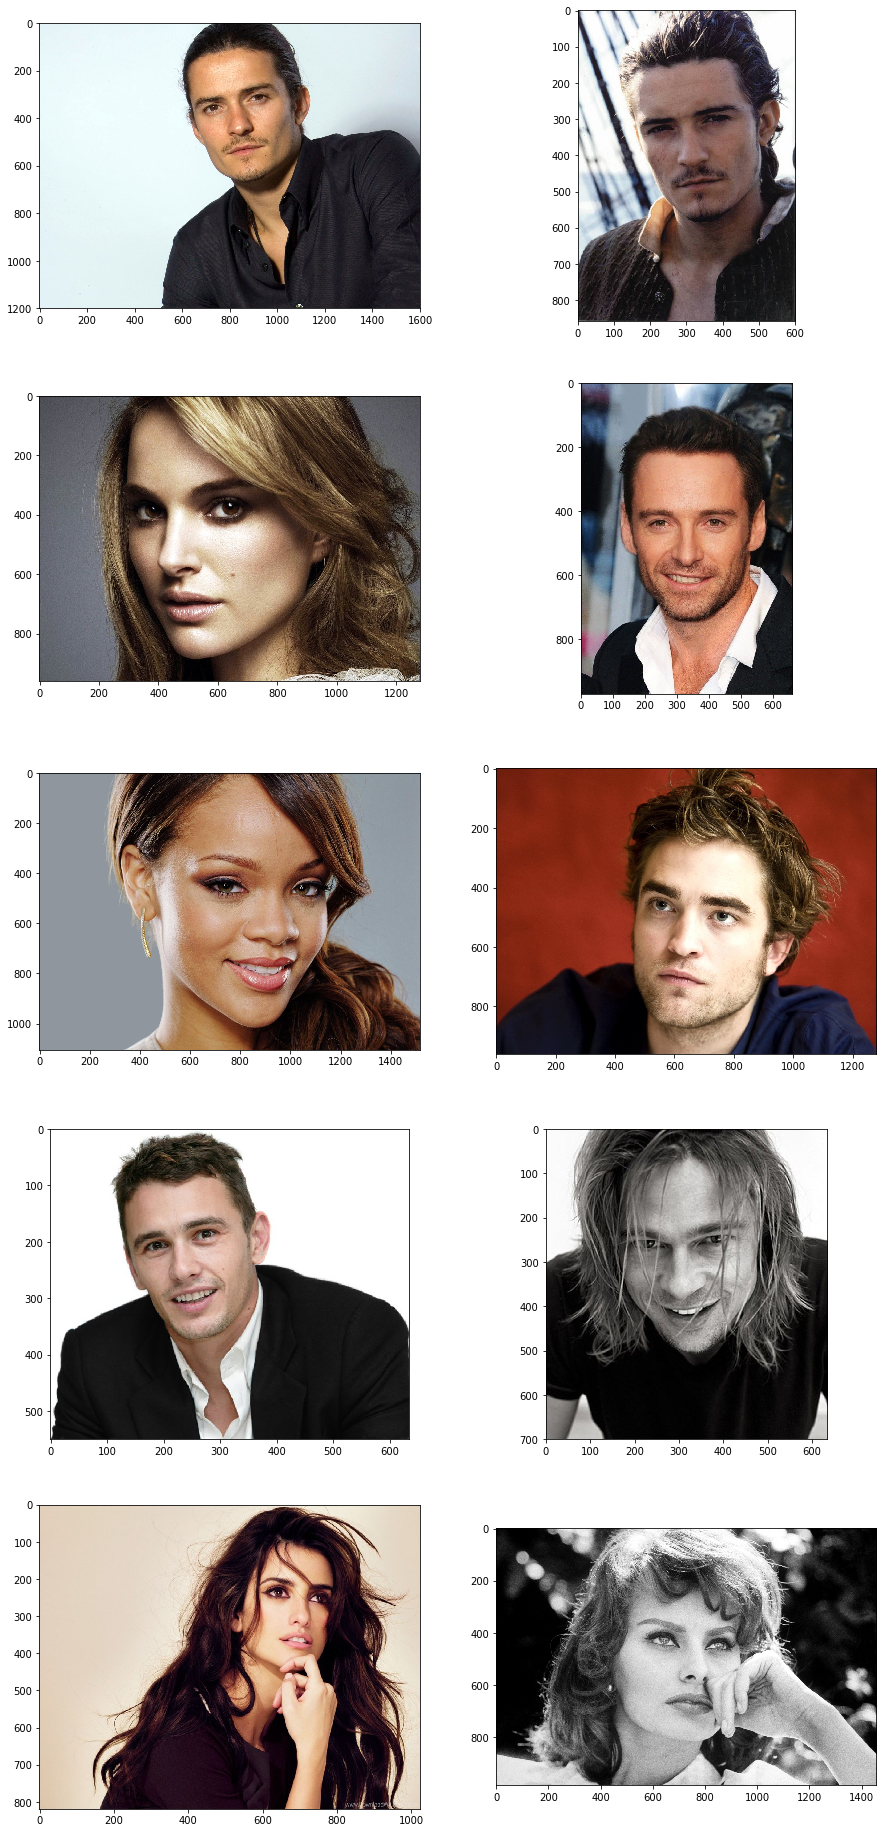

In [13]:
from matplotlib import pyplot as plt
import cv2
%matplotlib inline  

def load_images(annotations):
    images = []
    for image_name in annotations[:, 0]:
        images.append(cv2.imread('images\\' + image_name))
    return images

def show_images(images):
    '''
    Функция для ин-лайн отображения изображений
    Входные параметры:
    images: numpy uint8 массив изображений в формате BGR
    '''
    columns = 2
    images_count = len(images)
    plt.figure(figsize=(15,40))
    
    for i, image in enumerate(images):
        plt.subplot(images_count / columns + 1, columns, i + 1)
        image = image/255.
        plt.imshow(image[:,:,::-1])
    
images = load_images(annotations)

show_images(images)


# Отображение рамок лиц и лэндмарок
Здесь отобразите изображения с нарисованными рамками и лэндмарками

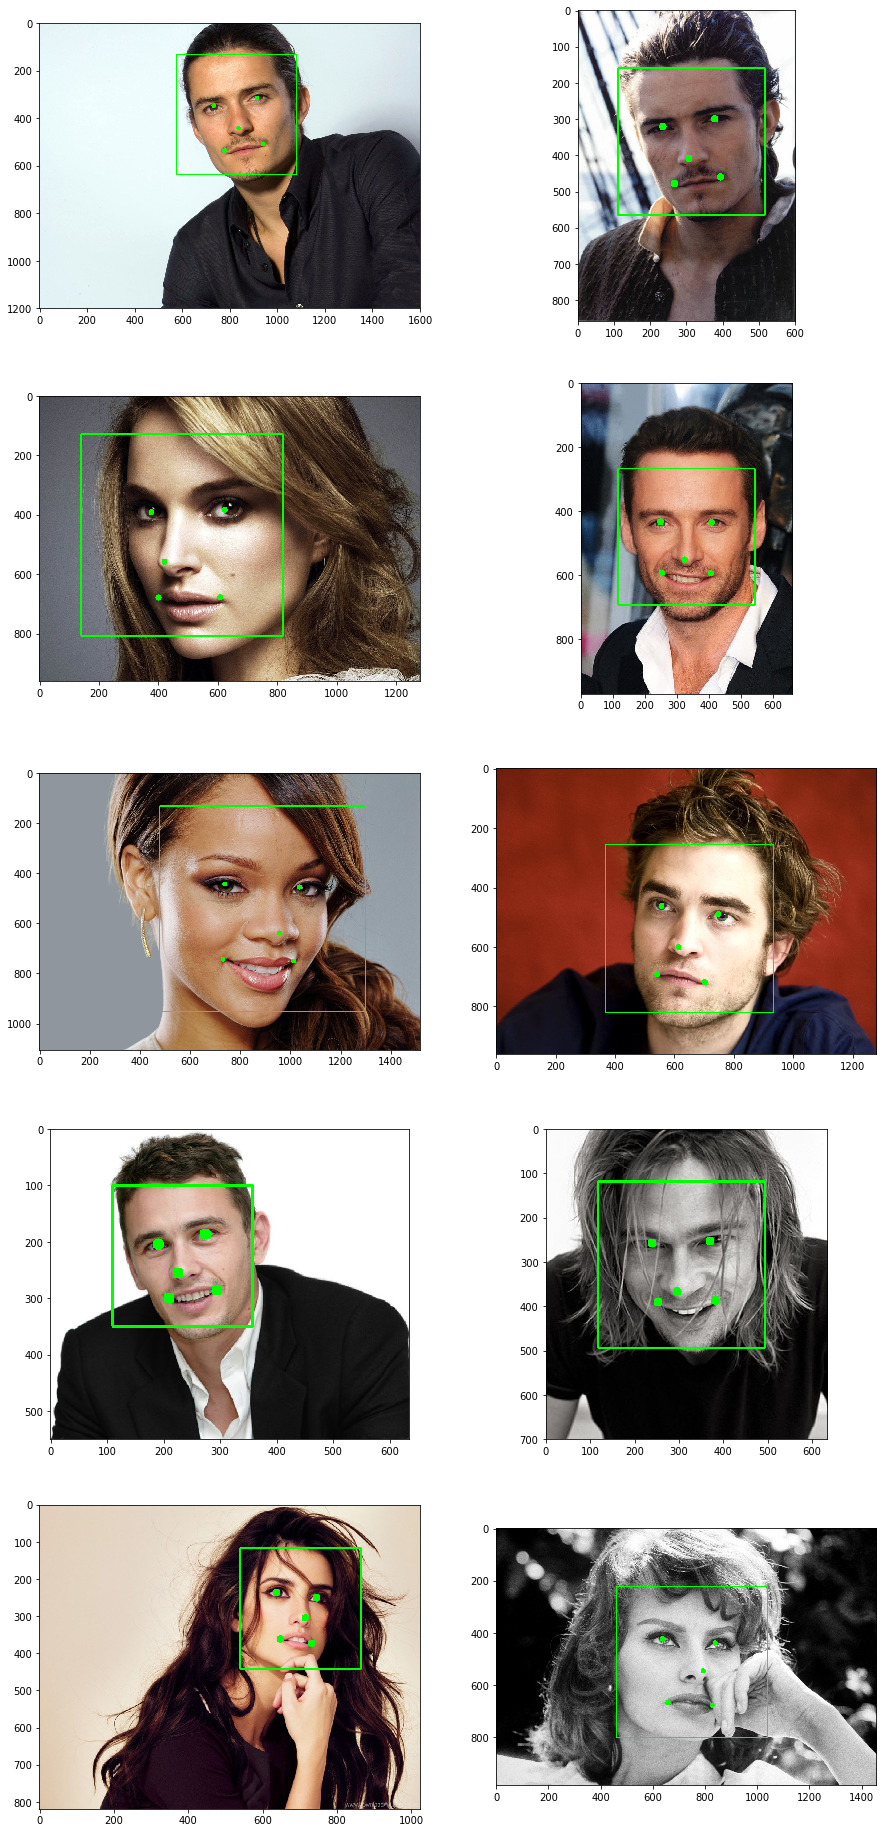

In [6]:

def draw_all_and_show_images(annotations):
    images = load_images(annotations)
    for i, image in enumerate(images):
        annotation = annotations[i]
        def get_cords(index):
            return int(float(annotation[index]) * image.shape[1]), int(float(annotation[index + 1]) * image.shape[0])
        def get_shifted_cords(index, x, y, w, h):
            return (int(float(annotation[index]) * w) + x, int(float(annotation[index + 1]) * h) + y)
        
        upper_x, upper_y = get_cords(1)
        bottom_x, bottom_y = get_cords(3)
        dots = []
        for i in range(5, 15, 2):
             dots.append(get_shifted_cords(i, upper_x, upper_y, bottom_x - upper_x, bottom_y - upper_y))
        
        for dot in dots:
            cv2.circle(image, dot,10, (0, 255, 0), -1)
        cv2.rectangle(image, (upper_x, upper_y), (bottom_x, bottom_y), (0, 255, 0),3)
        
    show_images(images)

draw_all_and_show_images(annotations)


# Подгон размера очков
Подгон размера очков к размеру фотомодели

In [85]:
#http://benjamintan.io/blog/2018/05/24/making-transparent-backgrounds-with-numpy-and-opencv-in-python/
glasses = cv2.imread('glasses.png')
glasses = cv2.cvtColor(glasses, cv2.COLOR_BGR2RGBA)
glasses = cv2.resize(glasses, None, fx = 0.27, fy = 0.285)
M = np.float32([[1,0,355],[0,1,520]])
glasses = cv2.warpAffine(glasses, M, (1200,1319), borderMode=1)
glasses[np.all(glasses == [255, 255, 255, 255], axis=2)] = [0, 0, 0, 0]


# Наложение модели очков
Здесь реализуйте автоматическое наложение очков на лица на основании ключевых точек (лэндмарок) и отобразите

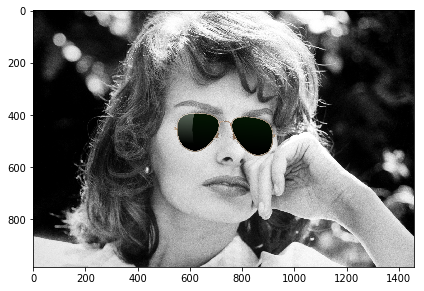

In [92]:

def magic(points, left_point):
    coefs = np.linalg.solve(points, left_point)
    res = np.copy(points).astype('float64')
    for i in range(3):
        res[:, i] *= coefs[i]
    return res

a_3_points = np.array([[485, 745, 515], [580, 580, 880], [1,1,1]])
a_4_point = np.array([715, 880, 1])

annotation = annotations[9] #тут
def get_cords(index):
    return int(float(annotation[index]) * images[9].shape[1]), int(float(annotation[index + 1]) * images[9].shape[0])# тут

def get_shifted_cords(index, x, y, w, h):
    return (int(float(annotation[index]) * w) + x, int(float(annotation[index + 1]) * h) + y)

upper_x, upper_y = get_cords(1)
bottom_x, bottom_y = get_cords(3)
dots = []
for i in range(5, 15, 2):
    dots.append(get_shifted_cords(i, upper_x, upper_y, bottom_x - upper_x, bottom_y - upper_y))
dots = np.array(dots)
dots = np.delete(dots,2,0)
dots = np.append(dots, np.ones((4,1)), 1).transpose()
b_3_points = dots[:,:3]
b_4_point = dots[:, 3]
def add_glasses_and_show_images(annotations):
    show_images(images)
    
A = magic(a_3_points, a_4_point) 
B = magic(b_3_points, b_4_point)
C = B.dot(np.linalg.inv(A))

w,h,c = images[9].shape #тут
res = cv2.warpPerspective(glasses, C, (h,w), borderMode=1)
alpha_s = res[:, :, 3] / 255.0
alpha_l = 1.0 - alpha_s
#https://stackoverflow.com/questions/14063070/overlay-a-smaller-image-on-a-larger-image-python-opencv
mdauh = cv2.cvtColor(images[9], cv2.COLOR_BGR2RGBA) # тут
for c in range(0, 3):
    mdauh[:,:, c] = (alpha_s * res[:, :, c] + alpha_l * mdauh[:, :, c])
mdauh = cv2.cvtColor(mdauh, cv2.COLOR_RGBA2BGR)
show_images([mdauh])
#add_glasses_and_show_images()